In [1]:
from __future__ import division, print_function

# Images in Astronomy

In this lesson we are going to look at aspects of processing and viewing images specific to Astronomy and Solar Astronomy. By the end of this lesson you should understand:

* Projected Coordinate Systems in Images
* World Coordinate Systems
* Using WCS to calculate coordinates in images
* Plotting images with WCS in images
* Using SunPy Map

## Projected Coordinate Systems

When taking images of the sky, we are projecting the spherical celestial coordinate system onto a 2-dimensional plane, which means that there is no simple linear relation between pixel coordinates and celestial coordinates

There are multiple coordinate systems used to describe the locations in 2D and 3D space for both Astronomy and Solar Physics. We shall use a couple of these systems here as examples but if you want to know more about them there are many of resources avalible.

### World Coordinate System

The FITS files have a standard for describing the physical coordinate system associated with imaging data, this is called the world coordinate system or WCS, sometimes the specific FITS version of this is referred to as FITS-WCS.

There are multiple papers describing the FITS-WCS standard for various types of data, there is a list here: http://fits.gsfc.nasa.gov/fits_wcs.html

As you learned in the previous lesson we can load FITS files with Astropy. To demonstrate a simple example of a FITS file with FITS-WCS information in the header we shall use an image from SunPy:

In [2]:
import sunpy.data
sunpy.data.download_sample_data()

Unpacking: aia.lev1.193A_2013-09-21T16_00_06.84Z.image_lev1.fits


In [3]:
from astropy.io import fits

In [4]:
from sunpy.data.sample import AIA_171_ROLL_IMAGE

In [5]:
hdulist = fits.open(AIA_171_ROLL_IMAGE)
type(hdulist)

astropy.io.fits.hdu.hdulist.HDUList

In [6]:
hdulist.info()

Filename: C:\Users\Ellie\sunpy\data\sample_data\aiacalibim5.fits.gz
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU     188   (4096, 4096)   int16   


In [7]:
hdu = hdulist[0]
hdu.header

 [astropy.io.fits.verify]



SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                 4096 / length of data axis 1                          
NAXIS2  =                 4096 / length of data axis 2                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
BLD_VERS= 'V8R4X'                                                               
LVL_NUM = 1.000000                                                              
T_REC   = '2014-04-09T06:00:14Z'                                                
TRECSTEP= 1.000000                                                              
TRECEPOC= '1977.01.01_00:00:

As you can see there are lots of keys in this and most other real world FITS headers. The ones we need to understand for FITS-WCS are:

Reference Pixel and Coordinate:

In [8]:
header = hdulist[0].header

print(header['CRVAL1'], header['CRVAL2'],)
print(header['CRPIX1'], header['CRPIX2'],)

0.0 0.0
2053.459961 2047.880005


Pixel resolution (at the reference pixel):

In [9]:
print(header['CDELT1'], header['CDELT2'],)

0.599489 0.599489


Rotation angle, in degress (at the reference pixel):

In [10]:
print( header['CROTA2'],)

-44.980717


Coordinate System and Projection:

In [11]:
print(header['CTYPE1'], header['CTYPE2'],)

HPLN-TAN HPLT-TAN


<section class="objectives panel panel-success">
<div class="panel-heading">
<h2><span class="fa fa-pencil"></span> Keyword Extraction </h2>
</div>

Extract and print out the `TELESCOP` value from the header.

Next, extract the `WAVELNTH` and `WAVEUNIT` values, use these to construct an astropy Quantity object for the wavelength of this image.



In [12]:
print(header['TELESCOP'])

SDO/AIA


In [13]:
print(header['WAVELNTH'])
print(header['WAVEUNIT'])

from astropy import units as u

wave = header['WAVELNTH'] *u.Unit(header['WAVEUNIT'])
wave

171
angstrom


<Quantity 171.0 Angstrom>

We could now sit down and work out how to convert from a pixel coordinate to a physical coordinate described by this header (Helioprojective).

However, we can cheat and just use Astropy.

In [14]:
from astropy.wcs import WCS
wcs = WCS(header)
wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'HPLN-TAN'  'HPLT-TAN'  
CRVAL : 0.0  0.0  
CRPIX : 2053.459961  2047.880005  
NAXIS    : 4096 4096

We can convert from pixel to world coordinate:

In [15]:
wcs.all_pix2world([[300,300]],0 )

array([[  3.59587957e+02,   5.18354457e-04]])

Or back again:

In [16]:
wcs.all_world2pix([[3.59587957e+02,   5.18354457e-04]],0 )

array([[ 300.00015266,  300.00015256]])

The last parameter to the two above examples is the 'origin' parameter. It is a flag that tells WCS if you indexes should be 0-based (like numpy) or 1-based (like FITS).
Here we are using 0 as we want to convert to and from numpy indexes of the array.

<section class="objectives panel panel-success">
<div class="panel-heading">
<h2><span class="fa fa-pencil"></span> How large is the image? </h2>
</div>
<br/>
To get a little practise using Astropy's WCS calculate the world coordinates of the following pixels:
<code>
[-500, 0]
[500, 500]
[0, 0]
</code>
<br/>
</section>

In [17]:
print(wcs.all_pix2world([[-500, 0]],0 ))
print(wcs.all_pix2world([[500, 500]],0 ))
print(wcs.all_pix2world([[0, 0]],0 ))

[[  3.59458420e+02   5.93474799e-02]]
[[  3.59635055e+02   5.34208718e-04]]
[[  3.59517311e+02   4.94572769e-04]]


## Plotting with wcsaxes

In this section we are going to use the wcsaxes package to make WCS aware image plots.

In [18]:
from astropy.io import fits
hdulist = fits.open('./h_n4571_f555_mosaic.fits.gz')
hdulist.info()

Filename: ./h_n4571_f555_mosaic.fits.gz
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU    1151   (4096, 4096)   float32   


For this example we are going to use a Hubble image.

In [31]:
%matplotlib nbagg
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


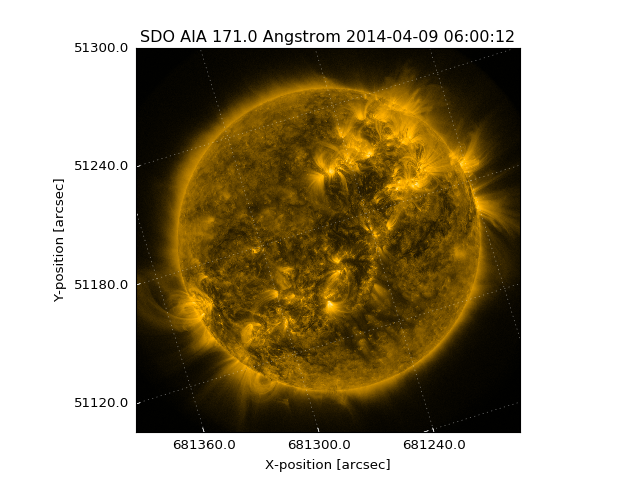

In [32]:
wcs = WCS(hdulist[0].header)
ax = plt.subplot(111, projection=wcs)
ax.imshow(hdulist[0].data, cmap='gray', vmax=1000, interpolation = 'none')

This image now has physcial labels in the native coordinate system of the image. We can see what the coordinate system and projection of this image is using the 'CTYPE' header entries we saw earlier.

In [21]:
print(hdulist[0].header['CTYPE1'], hdulist[0].header['CTYPE2'])

RA---TAN DEC--TAN


We can tell that this is in the FK5 coordinate system by the presence of a 'equinox' entry in the header:

In [22]:
hdulist[0].header['equinox']

2000.0

There is also a quick way to generate an Astropy coordinate frame from a WCS object, which confirms this diagnosis.

In [23]:
from astropy.wcs.utils import wcs_to_celestial_frame
wcs_to_celestial_frame(wcs)

<FK5 Frame (equinox=2000.0)>

for more information on the very useful `astropy.coordinates` module see http://docs.astropy.org/en/stable/coordinates/

<section class="objectives panel panel-success">
<div class="panel-heading">
<h2><span class="fa fa-pencil"></span> Add some labels </h2>
</div>
<br/>
Now we have a nice plot with physically meaningful ticks, we should label our axes.
<br/>

Add labels to the axes saying "Right Ascension [degrees]" and "Declination [degrees]"
<br/>

Also overlay a coordinate grid using:
<code>ax.coords.grid()</code>
Look up the documentation for this method to see what parameters you can specify.
<br/>
</section>

<IPython.core.display.Javascript object>


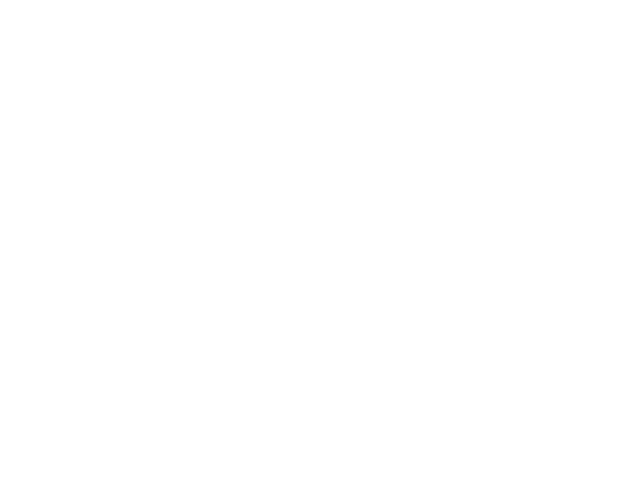

In [24]:
%matplotlib nbagg
import matplotlib.pyplot as plt

ax = plt.subplot(111, projection=wcs)
ax.set_ylabel('Right Ascension(degrees)')
ax.set_ylabel('Declination (degrees)')
ax.coords.grid(color ='Red', linestyle = 'solid')
ax.coords[0].set_ticks(spacing = 3*u.arcmin)
ax.coords[1].set_ticks(spacing = 3*u.arcmin)
ax.imshow(hdulist[0].data, cmap='gray', origin = 'lower', vmax=1000, interpolation = 'none')

ax.set_autoscale_on(False)

ax.plot(3000, 3000, 'x')
ax.plot(189.25, 14.23, 'o', transform=ax.get_transform('galactic'))



Now we have a nice plot, we can do a couple of things to plot.

### Overplotting in Pixel Coordinates

### Overplotting in World Coordinates

In [25]:
# Overplot in FK5 in Degrees


<section class="objectives panel panel-success">
<div class="panel-heading">
<h2><span class="fa fa-pencil"></span> Add some labels </h2>
</div>

Now overplot two lines on the image, one where you specified the line in pixel coordinates, and one where you specified the line in FK5 world coordinates.

</section>

In [26]:
# Overplot in FK5 in Degrees


###  Overplotting Another Coordinate System

## SunPy Map

The SunPy Map class is a wrapper for solar images which makes some of the above opertations easier.

In [27]:
import sunpy.map
from sunpy.data.sample import AIA_171_ROLL_IMAGE

C:\Users\Ellie\Anaconda2\lib\site-packages\glymur\lib\config.py:151: UserWarning: Neither the openjp2 nor the openjpeg library could be loaded.  
  warnings.warn(msg)


This has done a quick plot of the test image `AIA_171_ROLL_IMAGE` using wcsaxes.
If we want to customise the plot we use the `plot()` method.

<IPython.core.display.Javascript object>


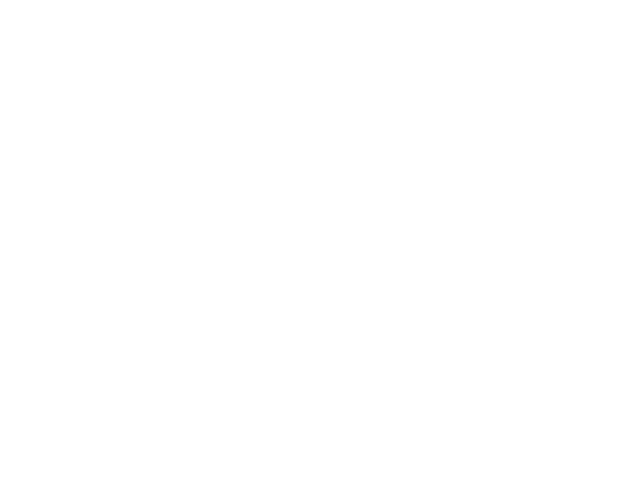

In [28]:
amap = sunpy.map.Map(AIA_171_ROLL_IMAGE)
amap.peek()

In [34]:
%matplotlib nbagg
import astropy.units as u
import matplotlib.pyplot as plt


<IPython.core.display.Javascript object>


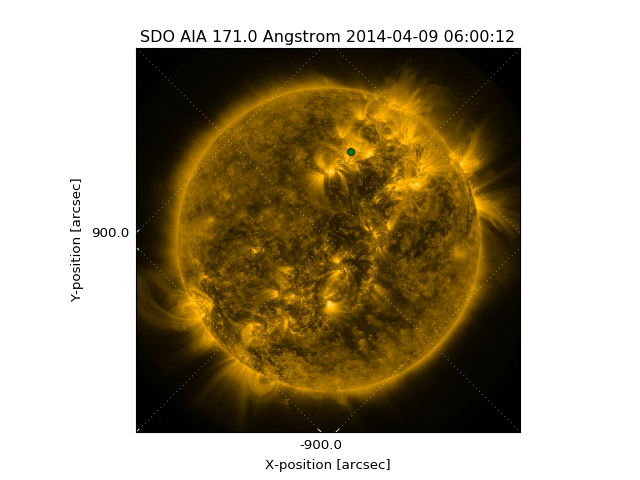

In [36]:
amap = sunpy.map.Map(AIA_171_ROLL_IMAGE)

im = amap.plot()
ax = plt.gca()
ax.set_autoscale_on(False)

x = 500*u.arcsec
y = 300*u.arcsec

ax.plot(x.to(u.deg), y.to(u.deg),'o', transform = ax.get_transform('world'))
plt.show()

<section class="objectives panel panel-success">
<div class="panel-heading">
<h2><span class="fa fa-pencil"></span> Rotate your Owl </h2>
</div>
Why is the Sun wonky?

Use the [`rotate()`](http://docs.sunpy.org/en/stable/code_ref/map.html#sunpy.map.mapbase.GenericMap.rotate) method of SunPy Map to align the coordinate grid to the pixel grid in this sample image.

Once you have run rotate, plot the resulting image, and compare with the one above.
</section>

In [42]:
rotate?

Object `rotate` not found.
